# <center> Table of contents</center>

##  <a href="#I.-Introducing-the-problem" style="color:#FF6666"> I. Introducing the problem </a>
<font color="#0000"> 
1. Introduction and problematization
2. Framework of the study
4. Description of the dataset
3. Score Metric


##  <a href="#II.-Data-Engineering" style="color:#FF6666"> II. Data Engineering </a>
<font color="#0000"> 

1. Treatment of the date
2. Acquisition of the sum of goals scored and conceded since the beginning of the season until the last game
3. Acquisition of the points of each team at the time of the game
4. Acquisition of the results of the last 3 matches
5. Acquisition of the number of shots
6. Acquisition of the number of shots on target in the last 2 matches
7. Acquisition of the number of red cards in the last game
8. Acquisition of the number of corners in the last two matches
9. Acquisition of the ranking at the end of the previous season as an additional independent variable
10. Acquisition of the Match day
11. Final Dataset

##  <a href="#III.-Data-Visualization" style="color:#FF6666"> III. Data Visualization </a>
<font color="#0000"> 
1. Familiarization with the world of soccer
2. Global look over the features
3. Numerical features
4. Categorical features


##  <a href="#IV.-Solving" style="color:#FF6666">  III. Solving </a>
<font color="#0000"> 
1. Workflow
2. Feature Extractor
3. Regressor
4. Evaluation
5. RAMP submission

#  <a style="color:#FF6666">I. Introducing the problem</a>


## 1. Introduction and problematization

In an era where most fields are undergoing their digital transformation, the world of sports is not spared [*(Les Echos*)](https://www.lesechos.fr/idees-debats/cercle/la-donnee-au-coeur-de-la-performance-dans-le-sport-134755): with the real increase of TV rights, and the support of global economic powers, some sports have become real businesses. This transformation involves the acquisition of brand new technologies: equipment and infrastructure, health, marketing, ultra-modern bikes, Formula 1 engines optimized in real time, ... and online betting. In all cases, the objective is the same: **to improve performance.**


Like all other areas, the sports betting industry has grown in recent years and is now considered a real industry. With the development of the internet and cell phones, online betting has never been easier, and this for all sports. Major players like Betclic, Winamax, Unibet, ZeBet, NetBet understood this early on, and have done everything to make betting as easy as possible. To generate hundreds of millions of euros, these companies exploit huge volumes of data every day. The main objective is to calculate "odds". According to the [*(Compare BET*)](https://www.compare-bet.fr/guides/les-cotes-aux-paris-sportifs.html#:~:text=La%20cote%20d'un%20%C3%A9v%C3%A9nement,multiples%20crit%C3%A8res%20et%20l'op%C3%A9ration.) website, an odds is "a number that defines both your potential gain and your chances of winning. It is calculated by the online betting operator based on multiple criteria and the transaction. The potential payout is the product of your stake and the odds".

By the terms "chances of winning" we mean "probabilities". But then, does it mean that every sports betting site calculates the probabilities of each sporting event for us? But what do they mean by "probabilities"? Is it a real probability? What is the model? Why do we have no visibility on this? And most importantly, why are the odds for the same game different for each betting site? As the definition says, the odds are calculated according to multiple criteria: the current ranking of the team, the number of goals scored in the last matches, the injured players. This information is fixed, these are facts. So why do the odds, which are supposed to be a probability, differ from site to site? This last point tells us that there is no absolute probability, given by an absolute model: if the odds of Winamax "PSG winning against Monaco" is 1.2, it does not necessarily mean that the probability of Paris winning against Monaco is 1/1.2=0.83. And why is that? Simply because, as we said, the goal is to improve the performance, and in this case, it is to make money. So each site puts an additional parameter into its models: money.

Faced with these biased probabilities that are the odds, which directly influence our choice, is it possible to establish a strategy that allows us to be more winning against these betting sites? How can we outsmart them? Is it possible to estimate the three probabilities of the events "Team A wins", "Draw", "Team B wins", with only the official parameters that everyone has (number of goals scored, ranking...)? Can we do it "by hand"? Every bettor knows: betting on a match is long and tedious. Indeed, a wise bettor takes into account a multitude of parameters, such as the history of results between the two teams, the form of these, the place of the match (home or away)... Making a strategy by hand is therefore very complicated. This is why we will use Machine Learning. Thus the objectives of our study will be the following:
- For each match, predict the three probabilities of the events "Team A wins", "Draw", "Team B wins".
- Determine the variables that play an important role in this prediction.
- Compare our results with the odds of a sports betting site to see if our strategy could make our bettor money.




## 2. Framework of the study

Among all the sports that are subject to sports betting, we choose to focus on Football. In Football, there are 3 outcomes per game: "Team A wins", "Draw", "Team B wins". It is therefore a multi-class classification problem.

Soccer is a sport played all over the world. We could have put the data of all the matches in the same database, but we would have to take into account an additional parameter: the country. We choose to focus on one country: England. 

The previous remark concerning the country is identical for the league: in the same country, there are several leagues corresponding to different levels. We choose to focus our study on the highest level league: the Premier League.

Finally, the same goes for the year. The Premier League was created in 1888. So we had to make a choice about the year: We focus on the matches between the season 2001/2002, and the season 2019/2020.

To summarize, we have chosen to focus on the following aspects: 
- Matches from the 2001/2002 season
- Matches until the 2018/2019 season
- Country: England
- League: Premier League

## 3. Description of the Dataset : 

The data as found on site [football-data.co.uk](https://www.football-data.co.uk/englandm.php) are constructed in the following way :
each file corresponds to a season. Each line of a file contains the statistics of one game. The first line corresponds to the first game of the season, and the last line corresponds to the last game of the season.

The variables contained in each file are given in the table below. We highlight the variables that we retain for the study. As we will see, these selected variables will be declined in other variables, which will already give a significant number of variables.


|  Feature name |  Signification | 
|-----------|-----------|
| Div |League Division| 
| **Date** |**Date of the match**| 
|Time|Time of match kick off|
|**HomeTeam**|**Home Team name**|
|**AwayTeam**|**Away Team name**|
|**FTHG**|**Full Time Home Team Goals**|
|**FTAG**|**Full Time Away Team Goals**|
|**FTR**|**Full Time Result (H=Home Win, D=Draw, A=Away Win)**|
|HTHG|Half Time Home Team Goals|
|HTAG|Half Time Away Team Goals|
|HTR|Half Time Result (H=Home Win, D=Draw, A=Away Win)|
|Attendance|Crowd Attendance|
|Referee|Match Referee|
|**HS**|**Home Team Shots**|
|**AS**|**Away Team Shots**|
|**HST**|**Home Team Shots on Target**|
|**AST**|**Away Team Shots on Target**|
|HHW|Home Team Hit Woodwork|
|AHW|Away Team Hit Woodwork|
|**HC**|**Home Team Corners**|
|**AC**|**Away Team Corners**|
|HF|Home Team Fouls Committed|
|AF|Away Team Fouls Committed|
|HFKC|Home Team Free Kicks Conceded|
|AFKC|Away Team Free Kicks Conceded|
|HO|Home Team Offsides|
|AO|Away Team Offsides|
|HY|Home Team Yellow Cards|
|AY|Away Team Yellow Cards|
|**HR**|**Home Team Red Cards**|
|**AR**|**Away Team Red Cards**|
|HBP|Home Team Bookings Points (10 = yellow, 25 = red)|
|ABP|Away Team Bookings Points (10 = yellow, 25 = red)|


The dataset is problematic for the following reason:

In general, you can bet up to 5 minutes before the start of the match. Recently, you can even bet during the match. But in our study, we will focus on the bet before the start of the game. Therefore, we have to use the data collected in the past. However, the database we have is not built in this sense: it is a database that associates to each match the statistics of this match. We must therefore perform a preliminary feature engineering step, where each line, i.e. each match, contains the statistics of the **previous** matches for the home team and the away team. Each variable will be preceded by the prefix "H_" for a statistic concerning the home team, and "A_" for the away team. For example, if we are interested in the Liverpool-Arsenal match, for the statistic "Shoots" we will have the variables :
- H_Shots1: Number of shots made by the Home Team in the previous match
- A_Shots1: Number of shots made by the Away Team in the previous match
- H_Shots2: Number of shots made by the Home Team in the second last match
- A_Shots2: Number of shots made by the Home Team in the second last game

Thus, for each line, we will have statistics like shots, corners... of the previous matches, for both team, in order to give an idea of the shape of the two teams.
The paragraph **II. Data Engineering** describes the different steps of the dataset creation.


## 4. Score Metric

We will use accuracy, balanced accuracy and f1 score as metrics for our model. These metrics are well suited to the multi-class classification task. We added the balanced accuracy because the classes are not exactly in the same proportion in the database. This is normal because a team is generally more likely to win at home.

# II. Data Engineering

We import the necessary packages and import the different files, downloaded from the site [football-data.co.uk](https://www.football-data.co.uk/englandm.php). As explained before, each files contains the match of a season.

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
loc = "/content/drive/My Drive/DataCamp/Datasets/"

raw_data_1 = pd.read_csv(loc + '2000-01.csv')
raw_data_2 = pd.read_csv(loc + '2001-02.csv')
raw_data_3 = pd.read_csv(loc + '2002-03.csv')
raw_data_4 = pd.read_csv(loc + '2003-04.csv', sep=';')
raw_data_5 = pd.read_csv(loc + '2004-05.csv', sep=';')
raw_data_6 = pd.read_csv(loc + '2005-06.csv')
raw_data_7 = pd.read_csv(loc + '2006-07.csv')
raw_data_8 = pd.read_csv(loc + '2007-08.csv')
raw_data_9 = pd.read_csv(loc + '2008-09.csv')
raw_data_10 = pd.read_csv(loc + '2009-10.csv')
raw_data_11 = pd.read_csv(loc + '2010-11.csv')
raw_data_12 = pd.read_csv(loc + '2011-12.csv')
raw_data_13 = pd.read_csv(loc + '2012-13.csv')
raw_data_14 = pd.read_csv(loc + '2013-14.csv')
raw_data_15 = pd.read_csv(loc + '2014-15.csv', sep=';')
raw_data_16 = pd.read_csv(loc + '2015-16.csv')
raw_data_17 = pd.read_csv(loc + '2016-17.csv')
raw_data_18 = pd.read_csv(loc + '2017-18.csv')
raw_data_19 = pd.read_csv(loc + '2018-19.csv')

If we display the names of the columns for the first season for example, we do find the names of the variables given in the previous table.

In [ ]:
raw_data_1.columns

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Attendance', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HHW',
       'AHW', 'HC', 'AC', 'HF', 'AF', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR',
       'HBP', 'ABP', 'GBH', 'GBD', 'GBA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD',
       'LBA', 'SBH', 'SBD', 'SBA', 'WHH', 'WHD', 'WHA'],
      dtype='object')

But, as we explained before, we choose to keep the variables in bold in the table : that's why we introduce the following list *columns_req* :

In [ ]:
columns_req = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
raw_data_1[columns_req].columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS',
       'HST', 'AST', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR'],
      dtype='object')

Let's take the selected variables for each season dataframe. As we have 19 seasons, we create a list of dataframes **statistics_all_seasons** which contains the 19 dataframes. Thus, to apply a fonction to each dataframe, we just have to use a for loop.

In [ ]:
#Acquisition of selected variables
statistics_all_seasons = []

statistics_all_seasons.append(raw_data_1[columns_req])
statistics_all_seasons.append(raw_data_2[columns_req])
statistics_all_seasons.append(raw_data_3[columns_req])
statistics_all_seasons.append(raw_data_4[columns_req])
statistics_all_seasons.append(raw_data_5[columns_req])
statistics_all_seasons.append(raw_data_6[columns_req])
statistics_all_seasons.append(raw_data_7[columns_req])
statistics_all_seasons.append(raw_data_8[columns_req])
statistics_all_seasons.append(raw_data_9[columns_req])
statistics_all_seasons.append(raw_data_10[columns_req])
statistics_all_seasons.append(raw_data_11[columns_req])  
statistics_all_seasons.append(raw_data_12[columns_req])
statistics_all_seasons.append(raw_data_13[columns_req])
statistics_all_seasons.append(raw_data_14[columns_req])
statistics_all_seasons.append(raw_data_15[columns_req])
statistics_all_seasons.append(raw_data_16[columns_req])
statistics_all_seasons.append(raw_data_17[columns_req])
statistics_all_seasons.append(raw_data_18[columns_req])
statistics_all_seasons.append(raw_data_19[columns_req])

## 1. Treatment of the date

Dates are not always written in the same format. We solve this problem below.

In [ ]:
# Processing of the dates for the tha majority of the seasons
def parse_date(date):
    if date == '':
        return None
    else:
        return (dt.strptime(date, '%d/%m/%y').date() - dt(2000,1,1).date()).days
    
# For the seasons 3, 18, and 19 the date format is different
def parse_date_other(date):
    if date == '':
        return None
    else:
        return (dt.strptime(date, '%d/%m/%Y').date() - dt(2000,1,1).date()).days

for num_season in range(19):
    if num_season in [2, 17, 18]:
        statistics_all_seasons[num_season].loc[:,'Date'].apply(parse_date_other) 
        statistics_all_seasons[num_season].loc[:,'Date'] = pd.to_datetime(statistics_all_seasons[num_season]['Date'], format="%d/%m/%Y")
    else:
        statistics_all_seasons[num_season].loc[:,'Date'].apply(parse_date)
        statistics_all_seasons[num_season].loc[:,'Date'] = pd.to_datetime(statistics_all_seasons[num_season]['Date'], format="%d/%m/%y")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
statistics_all_seasons[-1].head()


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HY,AY,HR,AR
0,2018-08-10,Man United,Leicester,2,1,H,8,13,6,4,2,5,2,1,0,0
1,2018-08-11,Bournemouth,Cardiff,2,0,H,12,10,4,1,7,4,1,1,0,0
2,2018-08-11,Fulham,Crystal Palace,0,2,A,15,10,6,9,5,5,1,2,0,0
3,2018-08-11,Huddersfield,Chelsea,0,3,A,6,13,1,4,2,5,2,1,0,0
4,2018-08-11,Newcastle,Tottenham,1,2,A,15,15,2,5,3,5,2,2,0,0


## 2. Acquisition of the sum of goals scored and conceded since the beginning of the season until the last game

Those variables can give an idea of comparison between two teams.

From the initial variable in the raw dataset 'FTHG'(Full Time Home Goals) and 'FTAG' (Full Time Away Goals), we create the 4 variables:
- H_GoalsScored : Home Team Goals Scored (Sum since the beginning of the season until the last game)
- A_GoalsScored : Away Team Goals Scored (Sum since the beginning of the season until the last game)
- H_GoalsConceded : Home Team Goals Conceded (Sum since the beginning of the season until the last game)
- A_GoalsConceded : Away Team Goals Conceded (Sum since the beginning of the season until the last game)

In [ ]:
# Acquisition of aggregate goals scored arranged by team and by week
def get_goals_scored(playing_stat):
    # Dictionary creation with team names as key
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().index:
        teams[i] = []
    
    # The value corresponding to the keys is the list containing the location of the matches
    for i in range(len(playing_stat)):
        HTGS = playing_stat.iloc[i]['FTHG']
        ATGS = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGS)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGS)
    
    # Creation of the dataframe for the goals scored where the rows are the teams and the columns are the game weeks
    GoalsScored = pd.DataFrame(data=teams, index = [i for i in range(1, 2*len(teams) - 1)]).T
    GoalsScored[0] = 0
    # Aggregation
    for i in range(2, 2*len(teams) - 1):
        GoalsScored[i] = GoalsScored[i] + GoalsScored[i-1]
    return GoalsScored


# Acquisition of aggregated conceded goals arranged by team and week
def get_goals_conceded(playing_stat):
    # Dictionary creation with team names as key
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().index:
        teams[i] = []
    
    # The value corresponding to the keys is the list containing the location of the matches
    for i in range(len(playing_stat)):
        ATGC = playing_stat.iloc[i]['FTHG']
        HTGC = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGC)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGC)
    
    # Creation of the dataframe for the goals conceded where the rows are the teams and the columns are the game weeks
    GoalsConceded = pd.DataFrame(data=teams, index = [i for i in range(1, 2*len(teams) - 1)]).T
    GoalsConceded[0] = 0
    # Aggregation
    for i in range(2, 2*len(teams) - 1):
        GoalsConceded[i] = GoalsConceded[i] + GoalsConceded[i-1]
    return GoalsConceded

def get_gss(playing_stat):
    playing_stat_c = playing_stat.copy()
    GC = get_goals_conceded(playing_stat)
    GS = get_goals_scored(playing_stat)
   
    j = 0
    HTGS = []
    ATGS = []
    HTGC = []
    ATGC = []

    for i in range(len(playing_stat)):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTGS.append(GS.loc[ht][j])
        ATGS.append(GS.loc[at][j])
        HTGC.append(GC.loc[ht][j])
        ATGC.append(GC.loc[at][j])
        
        if ((i + 1)% 10) == 0:
            j = j + 1
    
    playing_stat_c.loc[:,'H_GoalsScored'] = HTGS
    playing_stat_c.loc[:,'A_GoalsScored'] = ATGS
    playing_stat_c.loc[:,'H_GoalsConceded'] = HTGC
    playing_stat_c.loc[:,'A_GoalsConceded'] = ATGC
    
    return playing_stat_c


# Application to each dataframe
for num_season in range(19):
    statistics_all_seasons[num_season] = get_gss(statistics_all_seasons[num_season])

In [ ]:
statistics_all_seasons[-1]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HC,AC,HY,AY,HR,AR,H_GoalsScored,A_GoalsScored,H_GoalsConceded,A_GoalsConceded
0,2018-08-10,Man United,Leicester,2,1,H,8,13,6,4,2,5,2,1,0,0,0,0,0,0
1,2018-08-11,Bournemouth,Cardiff,2,0,H,12,10,4,1,7,4,1,1,0,0,0,0,0,0
2,2018-08-11,Fulham,Crystal Palace,0,2,A,15,10,6,9,5,5,1,2,0,0,0,0,0,0
3,2018-08-11,Huddersfield,Chelsea,0,3,A,6,13,1,4,2,5,2,1,0,0,0,0,0,0
4,2018-08-11,Newcastle,Tottenham,1,2,A,15,15,2,5,3,5,2,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2019-05-12,Liverpool,Wolves,2,0,H,13,7,5,2,4,1,0,2,0,0,87,47,22,44
376,2019-05-12,Man United,Cardiff,0,2,A,26,13,10,4,11,2,3,3,0,0,65,32,52,69
377,2019-05-12,Southampton,Huddersfield,1,1,D,10,10,3,3,4,3,0,1,0,0,44,21,64,75
378,2019-05-12,Tottenham,Everton,2,2,D,11,17,3,9,7,4,0,2,0,0,65,52,37,44


## 3. Acquisition of the points of each team at the time of the game

That is to say the points in the ranking at the time of the game.

From the initial variable in the raw dataset 'FTR'(Full Time Result), we create the 2 variables:
- H_Points : Home Team points just before playing the game
- A_Points : Away Team points just before playing the game




In [ ]:
def get_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0
    

def get_cuml_points(matchres):
    matchres_points = matchres.applymap(get_points)
    for i in range(2, 2*len(matchres.index) - 1):
        matchres_points[i] = matchres_points[i] + matchres_points[i-1]
        
    matchres_points.insert(column =0, loc = 0, value = [0*i for i in range(len(matchres.index))])
    return matchres_points


def get_matchres(playing_stat):
    # Dictionary creation with team names as key
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # The value corresponding to the keys is the list containing the location of the matches
    for i in range(len(playing_stat)):
        if playing_stat.iloc[i].FTR == 'H':
            teams[playing_stat.iloc[i].HomeTeam].append('W')
            teams[playing_stat.iloc[i].AwayTeam].append('L')
        elif playing_stat.iloc[i].FTR == 'A':
            teams[playing_stat.iloc[i].AwayTeam].append('W')
            teams[playing_stat.iloc[i].HomeTeam].append('L')
        else:
            teams[playing_stat.iloc[i].AwayTeam].append('D')
            teams[playing_stat.iloc[i].HomeTeam].append('D')
            
    return pd.DataFrame(data=teams, index = [i for i in range(1, 2*len(teams) - 1)]).T

def get_agg_points(playing_stat):
    playing_stat_c = playing_stat.copy()
    matchres = get_matchres(playing_stat)
    cum_pts = get_cuml_points(matchres)
    HTP = []
    ATP = []
    j = 0
    for i in range(len(playing_stat)):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTP.append(cum_pts.loc[ht][j])
        ATP.append(cum_pts.loc[at][j])

        if ((i + 1)% 10) == 0:
            j = j + 1
            
    playing_stat_c.loc[:,'H_Points'] = HTP
    playing_stat_c.loc[:,'A_Points'] = ATP
    return playing_stat_c
    
# Application to each dataframe
for num_season in range(19):
    statistics_all_seasons[num_season] = get_agg_points(statistics_all_seasons[num_season])

In [ ]:
statistics_all_seasons[-1]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,...,HY,AY,HR,AR,H_GoalsScored,A_GoalsScored,H_GoalsConceded,A_GoalsConceded,H_Points,A_Points
0,2018-08-10,Man United,Leicester,2,1,H,8,13,6,4,...,2,1,0,0,0,0,0,0,0,0
1,2018-08-11,Bournemouth,Cardiff,2,0,H,12,10,4,1,...,1,1,0,0,0,0,0,0,0,0
2,2018-08-11,Fulham,Crystal Palace,0,2,A,15,10,6,9,...,1,2,0,0,0,0,0,0,0,0
3,2018-08-11,Huddersfield,Chelsea,0,3,A,6,13,1,4,...,2,1,0,0,0,0,0,0,0,0
4,2018-08-11,Newcastle,Tottenham,1,2,A,15,15,2,5,...,2,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2019-05-12,Liverpool,Wolves,2,0,H,13,7,5,2,...,0,2,0,0,87,47,22,44,94,57
376,2019-05-12,Man United,Cardiff,0,2,A,26,13,10,4,...,3,3,0,0,65,32,52,69,66,31
377,2019-05-12,Southampton,Huddersfield,1,1,D,10,10,3,3,...,0,1,0,0,44,21,64,75,38,15
378,2019-05-12,Tottenham,Everton,2,2,D,11,17,3,9,...,0,2,0,0,65,52,37,44,70,53


## 4. Acquisition of the results of the last 3 matches

From the initial variable in the raw dataset 'FTR'(Full Time Result), we create the 6 variables:
- H_Results1 : Home Team last match result
- A_Results1 : Away Team last match result
- H_Results2 : Home Team second last match result
- A_Results2 : Away Team second last match result
- H_Results3 : Home Team third last match result
- A_Results3 : Away Team third last match result

In [ ]:
def get_form_results(playing_stat,num):
    form = get_matchres(playing_stat)
    form_final = form.copy()
    for i in range(num, 2*len(form.index) - 1):
        form_final[i] = ''
        j = 0
        while j < num:
            form_final[i] += form[i-j]
            j += 1           
    return form_final

def add_form_results(playing_stat,num):
    form = get_form_results(playing_stat,num)
    h = ['M' for i in range(num * 10)]       # Since the form is not available for n weeks of matches (n*10)
    a = ['M' for i in range(num * 10)]
    
    j = num
    for i in range((num*10), len(playing_stat)):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        
        past = form.loc[ht][j]               # Acquisition of the n past results
        h.append(past[num-1])                # indice 0 is the most recent
        
        past = form.loc[at][j]               # Acquisition of the n past results
        a.append(past[num-1])                # indice 0 is the most recent
        
        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['H_Results' + str(num)] = h                 
    playing_stat['A_Results' + str(num)] = a

    
    return playing_stat

# Application to each dataframe
for num_season in range(19):
    statistics_all_seasons[num_season] = add_form_results(statistics_all_seasons[num_season], 1)
    statistics_all_seasons[num_season] = add_form_results(statistics_all_seasons[num_season], 2)
    statistics_all_seasons[num_season] = add_form_results(statistics_all_seasons[num_season], 3)

statistics_all_seasons[-1]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,...,H_GoalsConceded,A_GoalsConceded,H_Points,A_Points,H_Results1,A_Results1,H_Results2,A_Results2,H_Results3,A_Results3
0,2018-08-10,Man United,Leicester,2,1,H,8,13,6,4,...,0,0,0,0,M,M,M,M,M,M
1,2018-08-11,Bournemouth,Cardiff,2,0,H,12,10,4,1,...,0,0,0,0,M,M,M,M,M,M
2,2018-08-11,Fulham,Crystal Palace,0,2,A,15,10,6,9,...,0,0,0,0,M,M,M,M,M,M
3,2018-08-11,Huddersfield,Chelsea,0,3,A,6,13,1,4,...,0,0,0,0,M,M,M,M,M,M
4,2018-08-11,Newcastle,Tottenham,1,2,A,15,15,2,5,...,0,0,0,0,M,M,M,M,M,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2019-05-12,Liverpool,Wolves,2,0,H,13,7,5,2,...,22,44,94,57,W,W,W,W,W,W
376,2019-05-12,Man United,Cardiff,0,2,A,26,13,10,4,...,52,69,66,31,D,L,D,L,L,L
377,2019-05-12,Southampton,Huddersfield,1,1,D,10,10,3,3,...,64,75,38,15,L,D,D,L,D,L
378,2019-05-12,Tottenham,Everton,2,2,D,11,17,3,9,...,37,44,70,53,L,W,L,D,W,W


## 5. Acquisition of the number of shots in the last 2 matches

From the initial variables in the raw dataset 'HS'(Home Team Shots) and 'AS' (Away Team Shots) we create the 4 variables:
- H_Shots1 : Home Team last match number of shots
- A_Shots1 : Away Team last match number of shots
- H_Shots2 : Home Team second last match number of shots
- A_Shots2 : Away Team second last match number of shots


In [ ]:
def get_matchres_shot(playing_stat):
    # Dictionary creation with team names as key
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # The value corresponding to the keys is the list containing the location of the matches
    for i in range(0, len(playing_stat)):
        teams[playing_stat.iloc[i].HomeTeam].append(playing_stat.iloc[i].HS)
        teams[playing_stat.iloc[i].AwayTeam].append(playing_stat.iloc[i].AS)
        
            
    return pd.DataFrame(data=teams, index = [i for i in range(1, 2*len(teams) - 1)]).T

def add_form_shot(playing_stat,num):
    form = get_matchres_shot(playing_stat)
    h = ['0' for i in range(num * 10)]          # Since the form is not available for n weeks of matches (n*10)
    a = ['0' for i in range(num * 10)]
    
    j = num + 1
    for i in range((num * 10), len(playing_stat)):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        
        past = form.loc[ht][j-num]               # Acquisition of the n past results
        h.append(past)                           # indice 0 is the most recent
        
        past = form.loc[at][j-num]               # Acquisition of the n past results
        a.append(past)                           # indice 0 is the most recent
        
        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['H_Shots' + str(num)] = h                 
    playing_stat['A_Shots' + str(num)] = a

    return playing_stat

# Application to each dataframe
for num_season in range(19):
    statistics_all_seasons[num_season] = add_form_shot(statistics_all_seasons[num_season], 1)
    statistics_all_seasons[num_season] = add_form_shot(statistics_all_seasons[num_season], 2)

statistics_all_seasons[-1]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,...,H_Results1,A_Results1,H_Results2,A_Results2,H_Results3,A_Results3,H_Shots1,A_Shots1,H_Shots2,A_Shots2
0,2018-08-10,Man United,Leicester,2,1,H,8,13,6,4,...,M,M,M,M,M,M,0,0,0,0
1,2018-08-11,Bournemouth,Cardiff,2,0,H,12,10,4,1,...,M,M,M,M,M,M,0,0,0,0
2,2018-08-11,Fulham,Crystal Palace,0,2,A,15,10,6,9,...,M,M,M,M,M,M,0,0,0,0
3,2018-08-11,Huddersfield,Chelsea,0,3,A,6,13,1,4,...,M,M,M,M,M,M,0,0,0,0
4,2018-08-11,Newcastle,Tottenham,1,2,A,15,15,2,5,...,M,M,M,M,M,M,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2019-05-12,Liverpool,Wolves,2,0,H,13,7,5,2,...,W,W,W,W,W,W,11,19,21,11
376,2019-05-12,Man United,Cardiff,0,2,A,26,13,10,4,...,D,L,D,L,L,L,23,18,7,13
377,2019-05-12,Southampton,Huddersfield,1,1,D,10,10,3,3,...,L,D,D,L,D,L,11,7,22,5
378,2019-05-12,Tottenham,Everton,2,2,D,11,17,3,9,...,L,W,L,D,W,W,11,20,14,22


## 6. Acquisition of the number of shots on target in the last 2 matches

From the initial variables in the raw dataset 'HST'(Home Team Shots on Target) and 'AST' (Away Team Shots on Target) we create the 4 variables:
- H_ShotsTarget1 : Home Team last match number of shots on target
- A_ShotsTarget1 : Away Team last match number of shots on target
- H_ShotsTarget2 : Home Team second last match number of shots on target
- A_ShotsTarget2 : Away Team second last match number of shots on target


In [ ]:
def get_matchres_shotT(playing_stat):
    # Dictionary creation with team names as key
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # The value corresponding to the keys is the list containing the location of the matches
    for i in range(0, len(playing_stat)):
        teams[playing_stat.iloc[i].HomeTeam].append(playing_stat.iloc[i].HST)
        teams[playing_stat.iloc[i].AwayTeam].append(playing_stat.iloc[i].AST)
        
            
    return pd.DataFrame(data=teams, index = [i for i in range(1, 2*len(teams) - 1)]).T


def add_form_shotT(playing_stat,num):
    form = get_matchres_shotT(playing_stat)
    h = ['0' for i in range(num * 10)]          # Since the form is not available for n weeks of matches (n*10)
    a = ['0' for i in range(num * 10)]
    
    j = num + 1
    for i in range((num * 10), len(playing_stat)):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        
        past = form.loc[ht][j-num]               # Acquisition of the n past results
        h.append(past)                           # Indice 0 is the most recent
        
        past = form.loc[at][j-num]               # Acquisition of the n past results
        a.append(past)                           # Indice 0 is the most recent
        
        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['H_ShotsTarget' + str(num)] = h                 
    playing_stat['A_ShotsTarget' + str(num)] = a

    
    return playing_stat

# Application to each dataframe
for num_season in range(19):
    statistics_all_seasons[num_season] = add_form_shotT(statistics_all_seasons[num_season], 1)
    statistics_all_seasons[num_season] = add_form_shotT(statistics_all_seasons[num_season], 2)

statistics_all_seasons[-1]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,...,H_Results3,A_Results3,H_Shots1,A_Shots1,H_Shots2,A_Shots2,H_ShotsTarget1,A_ShotsTarget1,H_ShotsTarget2,A_ShotsTarget2
0,2018-08-10,Man United,Leicester,2,1,H,8,13,6,4,...,M,M,0,0,0,0,0,0,0,0
1,2018-08-11,Bournemouth,Cardiff,2,0,H,12,10,4,1,...,M,M,0,0,0,0,0,0,0,0
2,2018-08-11,Fulham,Crystal Palace,0,2,A,15,10,6,9,...,M,M,0,0,0,0,0,0,0,0
3,2018-08-11,Huddersfield,Chelsea,0,3,A,6,13,1,4,...,M,M,0,0,0,0,0,0,0,0
4,2018-08-11,Newcastle,Tottenham,1,2,A,15,15,2,5,...,M,M,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2019-05-12,Liverpool,Wolves,2,0,H,13,7,5,2,...,W,W,11,19,21,11,4,6,7,4
376,2019-05-12,Man United,Cardiff,0,2,A,26,13,10,4,...,L,L,23,18,7,13,7,8,5,8
377,2019-05-12,Southampton,Huddersfield,1,1,D,10,10,3,3,...,D,L,11,7,22,5,1,3,7,1
378,2019-05-12,Tottenham,Everton,2,2,D,11,17,3,9,...,W,W,11,20,14,22,5,6,4,3


## 7. Acquisition of the number of red cards in the last game

From the initial variables in the raw dataset 'HR'(Home Team Red Cards) and 'AR' (Away Team Red Cards) we create the 2 variables:
- H_Red1 : Home Team last match number of Red Cards
- A_Red1 : Away Team last match number of Red Cards



In [ ]:
def get_matchres_R(playing_stat):
    # Dictionary creation with team names as key
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # The value corresponding to the keys is the list containing the results of the matches
    for i in range(0, len(playing_stat)):
        teams[playing_stat.iloc[i].HomeTeam].append(playing_stat.iloc[i].HR)
        teams[playing_stat.iloc[i].AwayTeam].append(playing_stat.iloc[i].AR)
        
            
    return pd.DataFrame(data=teams, index = [i for i in range(1, 2*len(teams) - 1)]).T

def add_form_R(playing_stat,num):
    form = get_matchres_R(playing_stat)
    h = ['0' for i in range(num * 10)]          # Since the form is not available for n weeks of matches (n*10)
    a = ['0' for i in range(num * 10)]
    
    j = num + 1
    for i in range((num * 10), len(playing_stat)):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        
        past = form.loc[ht][j-num]               # Acquisition of the n past results
        h.append(past)                           # Indice 0 is the most recent
        
        past = form.loc[at][j-num]               # Acquisition of the n past results
        a.append(past)                           # Indice 0 is the most recent
        
        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['H_Red' + str(num)] = h                 
    playing_stat['A_Red' + str(num)] = a

    
    return playing_stat

# Application to each dataframe
for num_season in range(19):
    statistics_all_seasons[num_season] = add_form_R(statistics_all_seasons[num_season], 1)

statistics_all_seasons[-1]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,...,H_Shots1,A_Shots1,H_Shots2,A_Shots2,H_ShotsTarget1,A_ShotsTarget1,H_ShotsTarget2,A_ShotsTarget2,H_Red1,A_Red1
0,2018-08-10,Man United,Leicester,2,1,H,8,13,6,4,...,0,0,0,0,0,0,0,0,0,0
1,2018-08-11,Bournemouth,Cardiff,2,0,H,12,10,4,1,...,0,0,0,0,0,0,0,0,0,0
2,2018-08-11,Fulham,Crystal Palace,0,2,A,15,10,6,9,...,0,0,0,0,0,0,0,0,0,0
3,2018-08-11,Huddersfield,Chelsea,0,3,A,6,13,1,4,...,0,0,0,0,0,0,0,0,0,0
4,2018-08-11,Newcastle,Tottenham,1,2,A,15,15,2,5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2019-05-12,Liverpool,Wolves,2,0,H,13,7,5,2,...,11,19,21,11,4,6,7,4,0,0
376,2019-05-12,Man United,Cardiff,0,2,A,26,13,10,4,...,23,18,7,13,7,8,5,8,0,0
377,2019-05-12,Southampton,Huddersfield,1,1,D,10,10,3,3,...,11,7,22,5,1,3,7,1,0,0
378,2019-05-12,Tottenham,Everton,2,2,D,11,17,3,9,...,11,20,14,22,5,6,4,3,2,0


## 8. Acquisition of the number of corners in the last two matches

From the initial variables in the raw dataset 'HC'(Home Team Corners) and 'AC' (Away Team Corners) we create the 4 variables:
- H_Corners1 : Home Team last match number of corners
- A_Corners1 : Away Team last match number of corners
- H_Corners2 : Home Team second last match number of corners
- A_Corners2 : Away Team second last match number of corners


In [ ]:
def get_matchres_C(playing_stat):
    # Dictionary creation with team names as key
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # The value corresponding to the keys is the list containing the results of the matches
    for i in range(0, len(playing_stat)):
        teams[playing_stat.iloc[i].HomeTeam].append(playing_stat.iloc[i].HC)
        teams[playing_stat.iloc[i].AwayTeam].append(playing_stat.iloc[i].AC)
        
            
    return pd.DataFrame(data=teams, index = [i for i in range(1, 2*len(teams) - 1)]).T

def add_form_C(playing_stat,num):
    form = get_matchres_C(playing_stat)
    h = ['0' for i in range(num * 10)]          # Since the form is not available for n weeks of matches (n*10)
    a = ['0' for i in range(num * 10)]
    
    j = num + 1
    for i in range((num * 10), len(playing_stat)):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        
        past = form.loc[ht][j-num]               # Acquisition of the n past results
        h.append(past)                           # Indice 0 is the most recent
        
        past = form.loc[at][j-num]               # Acquisition of the n past results
        a.append(past)                           # Indice 0 is the most recent
        
        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['H_Corners' + str(num)] = h                 
    playing_stat['A_Corners' + str(num)] = a

    return playing_stat

# Application to each dataframe
for num_season in range(19):
    statistics_all_seasons[num_season] = add_form_C(statistics_all_seasons[num_season], 1)
    statistics_all_seasons[num_season] = add_form_C(statistics_all_seasons[num_season], 2)

statistics_all_seasons[-1]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,...,H_ShotsTarget1,A_ShotsTarget1,H_ShotsTarget2,A_ShotsTarget2,H_Red1,A_Red1,H_Corners1,A_Corners1,H_Corners2,A_Corners2
0,2018-08-10,Man United,Leicester,2,1,H,8,13,6,4,...,0,0,0,0,0,0,0,0,0,0
1,2018-08-11,Bournemouth,Cardiff,2,0,H,12,10,4,1,...,0,0,0,0,0,0,0,0,0,0
2,2018-08-11,Fulham,Crystal Palace,0,2,A,15,10,6,9,...,0,0,0,0,0,0,0,0,0,0
3,2018-08-11,Huddersfield,Chelsea,0,3,A,6,13,1,4,...,0,0,0,0,0,0,0,0,0,0
4,2018-08-11,Newcastle,Tottenham,1,2,A,15,15,2,5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2019-05-12,Liverpool,Wolves,2,0,H,13,7,5,2,...,4,6,7,4,0,0,3,7,4,5
376,2019-05-12,Man United,Cardiff,0,2,A,26,13,10,4,...,7,8,5,8,0,0,7,10,6,3
377,2019-05-12,Southampton,Huddersfield,1,1,D,10,10,3,3,...,1,3,7,1,0,0,7,3,9,4
378,2019-05-12,Tottenham,Everton,2,2,D,11,17,3,9,...,5,6,4,3,2,0,6,8,2,10


At this points let's rearange the order of the columns :

In [ ]:
cols = ['Date', 
        'H_name', 'A_name', 
        'FTHG', 'FTAG', 'H_GoalsScored', 'A_GoalsScored', 'H_GoalsConceded', 'A_GoalsConceded',
        'FTR', 
        'H_Points', 'A_Points', 
        'H_Results1', 'H_Results2', 'H_Results3', 'A_Results1', 'A_Results2', 'A_Results3', 
        'H_Shots1', 'H_Shots2', 'A_Shots1', 'A_Shots2', 
        'H_ShotsTarget1', 'H_ShotsTarget2',  'A_ShotsTarget1', 'A_ShotsTarget2', 
        'H_Red1', 'A_Red1', 
        'H_Corners1', 'H_Corners2', 'A_Corners1', 'A_Corners2']

# Application to each dataframe
for num_season in range(19):
    statistics_all_seasons[num_season].rename(columns = {'HomeTeam' : 'H_name', 'AwayTeam' : 'A_name'}, inplace = True)
    statistics_all_seasons[num_season] = statistics_all_seasons[num_season][cols]

In [ ]:
statistics_all_seasons[-1]

,Date,H_name,A_name,FTHG,FTAG,H_GoalsScored,A_GoalsScored,H_GoalsConceded,A_GoalsConceded,FTR,...,H_ShotsTarget1,H_ShotsTarget2,A_ShotsTarget1,A_ShotsTarget2,H_Red1,A_Red1,H_Corners1,H_Corners2,A_Corners1,A_Corners2
0,2018-08-10,Man United,Leicester,2,1,0,0,0,0,H,...,0,0,0,0,0,0,0,0,0,0
1,2018-08-11,Bournemouth,Cardiff,2,0,0,0,0,0,H,...,0,0,0,0,0,0,0,0,0,0
2,2018-08-11,Fulham,Crystal Palace,0,2,0,0,0,0,A,...,0,0,0,0,0,0,0,0,0,0
3,2018-08-11,Huddersfield,Chelsea,0,3,0,0,0,0,A,...,0,0,0,0,0,0,0,0,0,0
4,2018-08-11,Newcastle,Tottenham,1,2,0,0,0,0,A,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2019-05-12,Liverpool,Wolves,2,0,87,47,22,44,H,...,4,7,6,4,0,0,3,4,7,5
376,2019-05-12,Man United,Cardiff,0,2,65,32,52,69,A,...,7,5,8,8,0,0,7,6,10,3
377,2019-05-12,Southampton,Huddersfield,1,1,44,21,64,75,D,...,1,7,3,1,0,0,7,9,3,4
378,2019-05-12,Tottenham,Everton,2,2,65,52,37,44,D,...,5,4,6,3,2,0,6,2,8,10


## 9. Acquisition of the ranking at the end of the previous season as an additional independent variable

From the initial variable in the raw dataset 'FTR'(Full Time Results)  we create the 2 variables:
- H_LastPosition : Home Team ranking at the end of the previous season
- A_LastPosition : Away Team ranking at the end of the previous season

When a team was not in the Premier League in the previous season, it means that this team was in a lower level league (as the Premier League is the top one). We chose to affect the value of the last position for such a team.

For the 2017/2018 season matches, we use the results from the previous 2016/2017 season to create our 2 new variables. Therefore, we cannot create these new variables for the first season. Therefore, we delete the dataset related to this season at the end of the cell.

In [ ]:
def get_last(playing_stat, playing_stat_last):
    teams = {}
    for i in playing_stat_last.groupby('H_name').mean().T.columns:
        teams[i] = 0
    
    for i in range(len(playing_stat_last) - 80, len(playing_stat_last)):
        if playing_stat_last.iloc[i].FTR == 'H':
            ATLTP = playing_stat_last.iloc[i]['A_Points']
            HTLTP = playing_stat_last.iloc[i]['H_Points'] + 3
        if playing_stat_last.iloc[i].FTR == 'A':
            ATLTP = playing_stat_last.iloc[i]['A_Points'] + 3
            HTLTP = playing_stat_last.iloc[i]['H_Points']
        if playing_stat_last.iloc[i].FTR == 'D':
            ATLTP = playing_stat_last.iloc[i]['A_Points'] + 1
            HTLTP = playing_stat_last.iloc[i]['H_Points'] + 1
        teams[playing_stat_last.iloc[i].H_name] = HTLTP
        teams[playing_stat_last.iloc[i].A_name] = ATLTP
    final_points = pd.Series(teams).sort_values(ascending = False)
    
    classement = {}
    for i in playing_stat.groupby('H_name').mean().index:
        classement[i] = 0
    classement = pd.Series(classement)

    for i in classement.index : 
        if i in final_points.index :
            classement[i] = final_points.index.get_loc(i) + 1
        else : 
            classement[i] = len(classement.index) - 1
            
    HomeTeamLP = []
    AwayTeamLP = []
    for i in range(len(playing_stat)):
        ht = playing_stat.iloc[i].H_name
        at = playing_stat.iloc[i].A_name
        HomeTeamLP.append(classement[ht])
        AwayTeamLP.append(classement[at])
    playing_stat_c = playing_stat.copy()
    playing_stat_c.loc[:, 'H_LastPosition'] = HomeTeamLP
    playing_stat_c.loc[:, 'A_LastPosition'] = AwayTeamLP
    return playing_stat_c

# Application to each dataframe
for num_season in range(1, 19):
    statistics_all_seasons[num_season] = get_last(statistics_all_seasons[num_season], statistics_all_seasons[num_season-1])

# Deletion of the first season because it cannot contain this new feature
del statistics_all_seasons[0]

In [ ]:
statistics_all_seasons[0][['Date', 'H_name', 'A_name', 'H_Points', 'A_Points', 'H_LastPosition', 'A_LastPosition']]

,Date,H_name,A_name,H_Points,A_Points,H_LastPosition,A_LastPosition
0,2001-08-18,Charlton,Everton,0,0,9,15
1,2001-08-18,Derby,Blackburn,0,0,16,19
2,2001-08-18,Leeds,Southampton,0,0,4,10
3,2001-08-18,Leicester,Bolton,0,0,13,19
4,2001-08-18,Liverpool,West Ham,0,0,3,17
...,...,...,...,...,...,...,...
375,2002-05-11,Liverpool,Ipswich,77,36,3,5
376,2002-05-11,Man United,Charlton,76,43,1,9
377,2002-05-11,Southampton,Newcastle,42,71,10,11
378,2002-05-11,Sunderland,Derby,39,29,7,16


## 10. Acquisition of the Match day

We create 1 variable :
- MatchDay : Number of the Match day at the moment of the match

The "Match day" is the english equivalent of the french "Journée". Each league has 20 teams. Each team meets 2 times each of the other teams. Thus, each team plays 2*19=38 matches. So, each of the 38 days, the 20 teams meet in 10 matches. However, for organizational and business reasons, these 10 matches do not take place on the same day. In general, they are spread over a week. But these 10 matches are for all the teams their k th meeting. Thus, we speak of the k th Match day. So this Match Day variable is an integer between 1 and 38 and allows to give an image of the progress of the season at the time when a match is played.

In [ ]:
def get_md(playing_stat):
    j = 1
    MatchDay = []
    for i in range(len(playing_stat)):
        MatchDay.append(j)
        if ((i + 1)% 10) == 0:
            j = j + 1
    playing_stat.loc[:, 'MatchDay'] = MatchDay
    return playing_stat

# Application to each dataframe
for num_season in range(18):
    statistics_all_seasons[num_season] = get_md(statistics_all_seasons[num_season])

In [ ]:
statistics_all_seasons[0][['Date', 'H_name', 'A_name', 'H_Points', 'A_Points', 'H_LastPosition', 'A_LastPosition', 'MatchDay']]

,Date,H_name,A_name,H_Points,A_Points,H_LastPosition,A_LastPosition,MatchDay
0,2001-08-18,Charlton,Everton,0,0,9,15,1
1,2001-08-18,Derby,Blackburn,0,0,16,19,1
2,2001-08-18,Leeds,Southampton,0,0,4,10,1
3,2001-08-18,Leicester,Bolton,0,0,13,19,1
4,2001-08-18,Liverpool,West Ham,0,0,3,17,1
...,...,...,...,...,...,...,...,...
375,2002-05-11,Liverpool,Ipswich,77,36,3,5,38
376,2002-05-11,Man United,Charlton,76,43,1,9,38
377,2002-05-11,Southampton,Newcastle,42,71,10,11,38
378,2002-05-11,Sunderland,Derby,39,29,7,16,38


## 11. Final dataset

We choose to concatenate all our season dataframes in a single dataframe. 

In [ ]:
final_dataset = pd.concat(statistics_all_seasons, ignore_index=True)         
final_dataset

,Date,H_name,A_name,FTHG,FTAG,H_GoalsScored,A_GoalsScored,H_GoalsConceded,A_GoalsConceded,FTR,...,A_ShotsTarget2,H_Red1,A_Red1,H_Corners1,H_Corners2,A_Corners1,A_Corners2,H_LastPosition,A_LastPosition,MatchDay
0,2001-08-18,Charlton,Everton,1,2,0,0,0,0,A,...,0,0,0,0,0,0,0,9,15,1
1,2001-08-18,Derby,Blackburn,2,1,0,0,0,0,H,...,0,0,0,0,0,0,0,16,19,1
2,2001-08-18,Leeds,Southampton,2,0,0,0,0,0,H,...,0,0,0,0,0,0,0,4,10,1
3,2001-08-18,Leicester,Bolton,0,5,0,0,0,0,A,...,0,0,0,0,0,0,0,13,19,1
4,2001-08-18,Liverpool,West Ham,2,1,0,0,0,0,H,...,0,0,0,0,0,0,0,3,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835,2019-05-12,Liverpool,Wolves,2,0,87,47,22,44,H,...,4,0,0,3,4,7,5,4,19,38
6836,2019-05-12,Man United,Cardiff,0,2,65,32,52,69,A,...,8,0,0,7,6,10,3,2,19,38
6837,2019-05-12,Southampton,Huddersfield,1,1,44,21,64,75,D,...,1,0,0,7,9,3,4,17,16,38
6838,2019-05-12,Tottenham,Everton,2,2,65,52,37,44,D,...,3,2,0,6,2,8,10,3,8,38


We have created all our new variables. Now, we remove the initial variables which do not belong to the past : FTHG and FTAG. But we keep the variable 'FTR' (Full Time Result) since it is our output variable.

In [ ]:
# Remove statistics which not belong to the past : 
final_dataset.drop(columns = ['FTHG', 'FTAG'], inplace = True)
final_dataset.rename(columns = {'FTR' : 'Result'}, inplace = True)
final_dataset = final_dataset[['Date', 'H_name', 'A_name', 'H_GoalsScored',
       'A_GoalsScored', 'H_GoalsConceded', 'A_GoalsConceded',
       'H_Points', 'A_Points', 'H_Results1', 'H_Results2', 'H_Results3',
       'A_Results1', 'A_Results2', 'A_Results3', 'H_Shots1', 'H_Shots2',
       'A_Shots1', 'A_Shots2', 'H_ShotsTarget1', 'H_ShotsTarget2',
       'A_ShotsTarget1', 'A_ShotsTarget2', 'H_Red1', 'A_Red1', 'H_Corners1',
       'H_Corners2', 'A_Corners1', 'A_Corners2', 'H_LastPosition',
       'A_LastPosition', 'MatchDay', 'Result']]

One might think that our final database contains a lot of variables. This impression comes from the fact that each sample involves two teams. Thus, each criterion (e.g. number of shots, number of corners...) is measured for both teams during each match. We store this final dataset in a file named *final_dataset.csv*

In [ ]:
import os
path = '.'
f_name = 'data_train.csv'
os.path.join(path, 'data', f_name)

'./data/data_train.csv'

We choose to remove the feature 'Date' for the `final_dataset`. We consider that the feature 'Match day' gives a picture of the progress of the season. We keep a dataframe named `final_dataset_viz` which keeps the dates in order to do the visualization.

In [ ]:
final_dataset_viz = final_dataset.copy()
final_dataset.drop(columns = ['Date'], inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
final_dataset.to_csv(loc + "final_dataset.csv")
final_dataset_viz.to_csv(loc + "final_dataset_viz.csv")

# III. Data Visualization

Load the data

In [ ]:
final_dataset = pd.read_csv(loc +"final_dataset_viz.csv")
final_dataset.drop(columns = ['Unnamed: 0'], inplace = True)
final_dataset

,Date,H_name,A_name,H_GoalsScored,A_GoalsScored,H_GoalsConceded,A_GoalsConceded,H_Points,A_Points,H_Results1,...,H_Red1,A_Red1,H_Corners1,H_Corners2,A_Corners1,A_Corners2,H_LastPosition,A_LastPosition,MatchDay,Result
0,2001-08-18,Charlton,Everton,0,0,0,0,0,0,M,...,0,0,0,0,0,0,9,15,1,A
1,2001-08-18,Derby,Blackburn,0,0,0,0,0,0,M,...,0,0,0,0,0,0,16,19,1,H
2,2001-08-18,Leeds,Southampton,0,0,0,0,0,0,M,...,0,0,0,0,0,0,4,10,1,H
3,2001-08-18,Leicester,Bolton,0,0,0,0,0,0,M,...,0,0,0,0,0,0,13,19,1,A
4,2001-08-18,Liverpool,West Ham,0,0,0,0,0,0,M,...,0,0,0,0,0,0,3,17,1,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835,2019-05-12,Liverpool,Wolves,87,47,22,44,94,57,W,...,0,0,3,4,7,5,4,19,38,H
6836,2019-05-12,Man United,Cardiff,65,32,52,69,66,31,D,...,0,0,7,6,10,3,2,19,38,A
6837,2019-05-12,Southampton,Huddersfield,44,21,64,75,38,15,L,...,0,0,7,9,3,4,17,16,38,D
6838,2019-05-12,Tottenham,Everton,65,52,37,44,70,53,L,...,2,0,6,2,8,10,3,8,38,D


## 1. Familiarization with the world of soccer

To begin data vizualization, let's familiarize with soccer :

As we said before, for each season, there are 20 teams. For example, let's display the teams of the season 2018/2019:

In [ ]:
season_2018_2019 = final_dataset[('2018-08-10'<=final_dataset['Date']) & (final_dataset['Date']<= '2019-05-12')]
season_2018_2019["H_name"].unique()

array(['Man United', 'Bournemouth', 'Fulham', 'Huddersfield', 'Newcastle',
       'Watford', 'Wolves', 'Arsenal', 'Liverpool', 'Southampton',
       'Cardiff', 'Chelsea', 'Everton', 'Leicester', 'Tottenham',
       'West Ham', 'Brighton', 'Burnley', 'Man City', 'Crystal Palace'],
      dtype=object)

Each team meets an other team two times in a season, what makes 38 matches for each team. Let's for example display the result of Liverpool during the season 2018/2019 : A 1 corresponds to a win, a 0.5 corresponds to a draw, and a 0 corresponds to a lose.

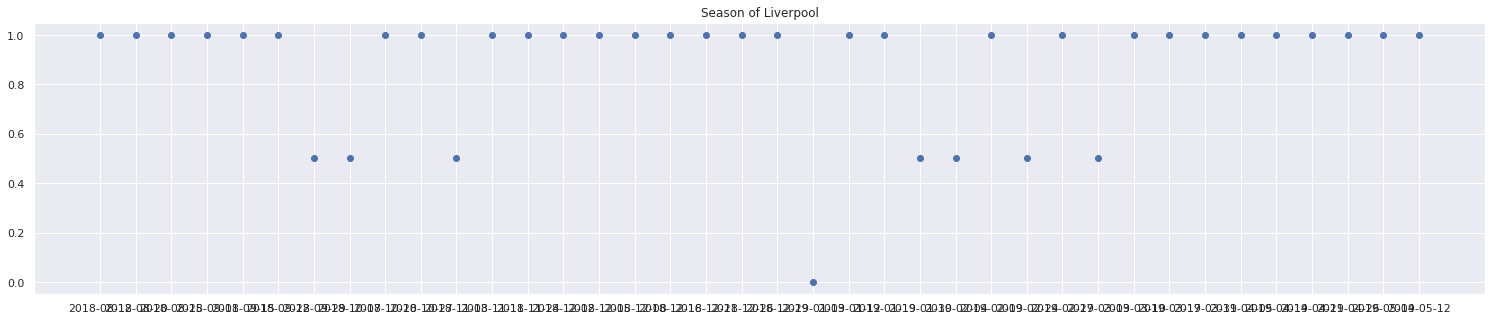

In [ ]:
season_2018_2019_Liverpool = season_2018_2019.copy()[(season_2018_2019['H_name']=='Liverpool') | (season_2018_2019['A_name']=='Liverpool')]
res_liv = []
for num_match in range(len(season_2018_2019_Liverpool)):
    if season_2018_2019_Liverpool.iloc[num_match]['H_name']=='Liverpool':
        if season_2018_2019_Liverpool.iloc[num_match]['Result'] == 'H':
              res_liv.append(1)
        elif season_2018_2019_Liverpool.iloc[num_match]['Result'] == 'D':
              res_liv.append(0.5)
        else:
              res_liv.append(0)
    else:
        if season_2018_2019_Liverpool.iloc[num_match]['Result'] == 'H':
              res_liv.append(0)
        elif season_2018_2019_Liverpool.iloc[num_match]['Result'] == 'D':
              res_liv.append(0.5)
        else:
              res_liv.append(1)

season_2018_2019_Liverpool['Res_Liv'] = res_liv

plt.figure(figsize=(26,5))
plt.scatter(season_2018_2019_Liverpool['Date'], season_2018_2019_Liverpool['Res_Liv'])
plt.title('Season of Liverpool')
plt.show()

As we can see, Liverpool has had a majority of wins in this season. Let's compare to a lower level team : Fulham

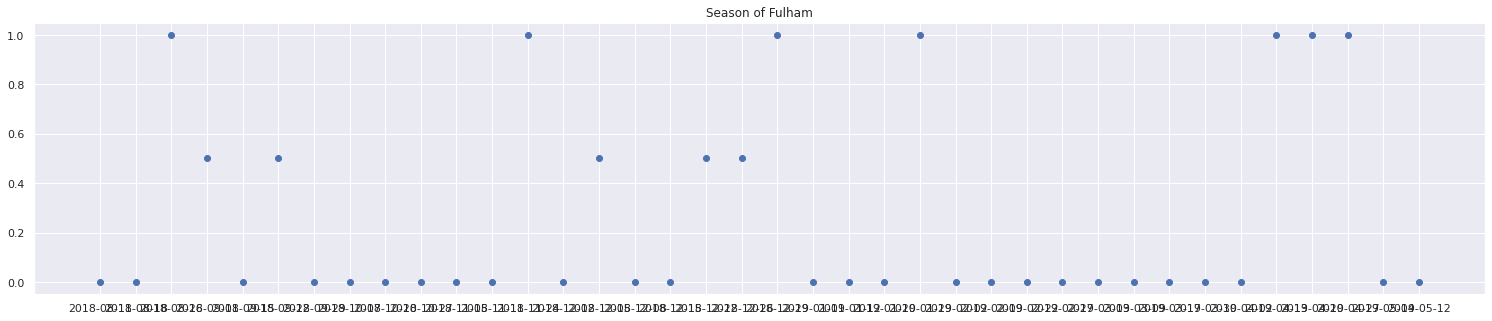

In [ ]:
season_2018_2019_Fulham = season_2018_2019.copy()[(season_2018_2019['H_name']=='Fulham') | (season_2018_2019['A_name']=='Fulham')]
res_Fulham = []
for num_match in range(len(season_2018_2019_Fulham)):
    if season_2018_2019_Fulham.iloc[num_match]['H_name']=='Fulham':
        if season_2018_2019_Fulham.iloc[num_match]['Result'] == 'H':
              res_Fulham.append(1)
        elif season_2018_2019_Fulham.iloc[num_match]['Result'] == 'D':
              res_Fulham.append(0.5)
        else:
              res_Fulham.append(0)
    else:
        if season_2018_2019_Fulham.iloc[num_match]['Result'] == 'H':
              res_Fulham.append(0)
        elif season_2018_2019_Fulham.iloc[num_match]['Result'] == 'D':
              res_Fulham.append(0.5)
        else:
              res_Fulham.append(1)

season_2018_2019_Fulham['Res_Fulham'] = res_Fulham

plt.figure(figsize=(26,5))
plt.scatter(season_2018_2019_Fulham['Date'], season_2018_2019_Fulham['Res_Fulham'])
plt.title('Season of Fulham')
plt.show()

Some teams are historically good at football, that means those teams always remain in the best league : the Premier League. That is the case of Liverpool, Manchester United and Chelsea. Otherwise, there are some teams which played a few games, maybe during 1 season only, as we can see below : A high number of games played can be an indicator about the global level of a team.

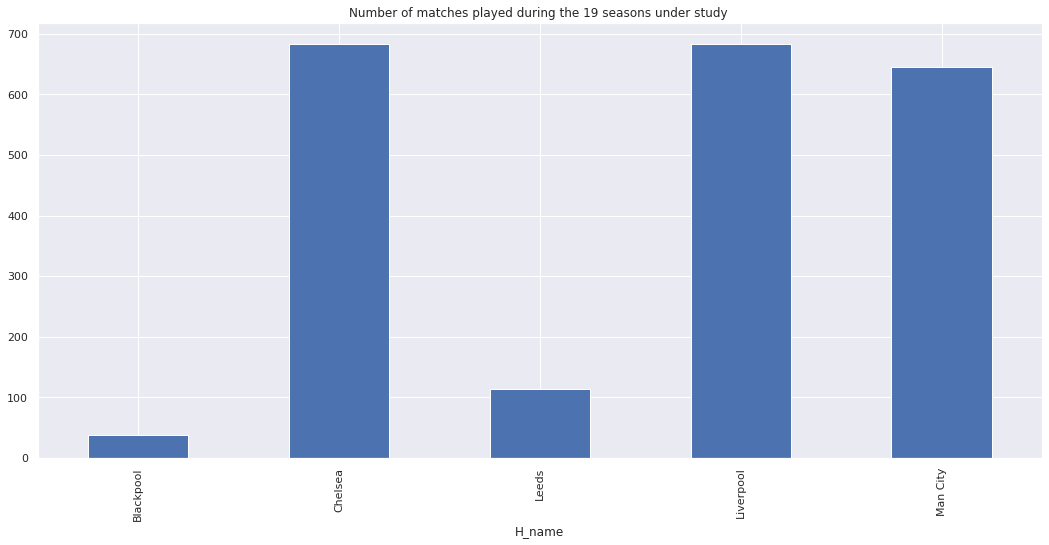

In [ ]:
difference = final_dataset[(final_dataset["H_name"]=='Liverpool') | (final_dataset["H_name"]=='Chelsea') | (final_dataset["H_name"]=='Man City')|(final_dataset["H_name"]=='Leeds') | (final_dataset["H_name"]=='Blackpool')]
sns.set(rc={'figure.figsize':(18,8)})
#ax = sns.countplot(data = difference, x = 'H_name', hue='Result').set_title('Number of matchs played at home')
participations = 2*difference.groupby('H_name')['Date'].count().copy()
plt.title("Number of matches played during the 19 seasons under study ")
ax = participations.plot(kind='bar')

## 2. Global look over the features

Let's recall the different variables :


|  Feature name |  Signification | 
|-----------|-----------|
| Date |Date of the match| 
|H_name|Name of the Home team|
|A_name|Name of the Away team|
|H_GoalsScored|Sum of goals scored by the Home Team since the beginning of the season until the last game|
|A_GoalsScored|Sum of goals scored by the Away Team since the beginning of the season until the last game|
|H_GoalsConceded|Sum of goals conceded by the Home Team since the beginning of the season until the last game|
|A_GoalsConceded|Sum of goals conceded by the Away Team since the beginning of the season until the last game|
|H_Points|Number of points of the Home Team at the beginning of the match|
|A_Points|Number of points of the Away Team at the beginning of the match|
|H_Results1|Result of the last match of the Home Team|
|H_Results2|Result of the second last match of the Home Team|
|H_Results3|Result of the third last match of the Home Team|
|A_Results1|Result of the last match of the Away Team|
|A_Results2|Result of the second last match of the Away Team|
|A_Results3|Result of the third last match of the Away Team|
|H_Shots1|Number of shots made by the Home Team during its last match|
|H_Shots2|Number of shots made by the Home Team during its second last match|
|A_Shots1|Number of shots made by the Away Team during its last match|
|A_Shots2|Number of shots made by the Away Team during its second last match|
|H_ShotsTarget1|Number of shots on target made by the Home Team during its last match|
|H_ShotsTarget2|Number of shots on target made by the Home Team during its second last match|
|A_ShotsTarget1|Number of shots on target made by the Away Team during its last match|
|A_ShotsTarget2|Number of shots on target made by the Away Team during its second last match|
|H_Red1|Number of red cards the Home Team received during its last match|
|A_Red1|Number of red cards the Away Team received during its last match|
|H_Corners1|Number of corners made by the Home Team during its last match|
|H_Corners2|Number of corners made by the Home Team during its second last match|
|A_Corners1|Number of corners made by the Away Team during its last match|
|A_Corners2|Number of corners made by the Away Team during its second last match|
|H_LastPosition|Home Team ranking at the end of the previous season |
|A_LastPosition|Away Team ranking at the end of the previous season |
|MatchDay|Number of the game day|
|Result|Result of the match|


After having described each feature, let's look at the different values each feature takes:

In [ ]:
for var in final_dataset.columns:
    values = final_dataset[var].unique()
    print(var  +  ': '+ str(values[:8]))

Date: ['2001-08-18' '2001-08-19' '2001-08-20' '2001-08-21' '2001-08-22'
 '2001-08-25' '2001-08-26' '2001-08-27']
H_name: ['Charlton' 'Derby' 'Leeds' 'Leicester' 'Liverpool' 'Middlesbrough'
 'Sunderland' 'Tottenham']
A_name: ['Everton' 'Blackburn' 'Southampton' 'Bolton' 'West Ham' 'Arsenal'
 'Ipswich' 'Aston Villa']
H_GoalsScored: [0 2 4 5 1 3 6 8]
A_GoalsScored: [0 2 3 1 4 5 6 9]
H_GoalsConceded: [0 1 2 3 4 9 6 5]
A_GoalsConceded: [ 0  4  1  2  5  3  6 10]
H_Points: [0 3 1 2 6 4 5 9]
A_Points: [0 1 3 4 6 5 7 2]
H_Results1: ['M' 'W' 'L' 'D']
H_Results2: ['M' 'L' 'D' 'W']
H_Results3: ['M' 'W' 'L' 'D']
A_Results1: ['M' 'D' 'W' 'L']
A_Results2: ['M' 'L' 'D' 'W']
A_Results3: ['M' 'D' 'W' 'L']
H_Shots1: [ 0 12 14 18 10  8 30 11]
H_Shots2: [ 0 10 11  3  9 18 13  7]
A_Shots1: [ 0  8 16  6  7 12 13  5]
A_Shots2: [ 0  8 13 16 12  9 14  3]
H_ShotsTarget1: [ 0  9  8  4  5 18  2  3]
H_ShotsTarget2: [0 4 6 3 2 8 1 7]
A_ShotsTarget1: [ 0  2  6  3  1  7  5 18]
A_ShotsTarget2: [ 0  4  8  6  9  3 11  5]

Of course there are numerical variables, but these variables take a finite number of values. They are rather categorical variables.

Let's now observe the shape, the types, and the missing values:

In [ ]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6840 entries, 0 to 6839
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             6840 non-null   object
 1   H_name           6840 non-null   object
 2   A_name           6840 non-null   object
 3   H_GoalsScored    6840 non-null   int64 
 4   A_GoalsScored    6840 non-null   int64 
 5   H_GoalsConceded  6840 non-null   int64 
 6   A_GoalsConceded  6840 non-null   int64 
 7   H_Points         6840 non-null   int64 
 8   A_Points         6840 non-null   int64 
 9   H_Results1       6840 non-null   object
 10  H_Results2       6840 non-null   object
 11  H_Results3       6840 non-null   object
 12  A_Results1       6840 non-null   object
 13  A_Results2       6840 non-null   object
 14  A_Results3       6840 non-null   object
 15  H_Shots1         6840 non-null   int64 
 16  H_Shots2         6840 non-null   int64 
 17  A_Shots1         6840 non-null   

- We have in total 6840 independant samples, each corresponding to a match. Let's remember that every sample is independant thanks to the way we "created" the dataset. We have 32 features which quantify general performances of the Home and Away teams, and more recent ones which consider the last, second last, and third last games. Those last ones give an image of the current shape of the teams.

- The types are consistent : the string are typed as objects, and the other features are typed as integers. But, as we said before, some features are clearly categorical variables (for example the MatchDay, the number of red cards...).

- Thanks to the way we "created" ourselves the dataset, there is no missing values.

## Distribution of the variable to be predicted

Let's count the number of occurences of each of the possible target values :

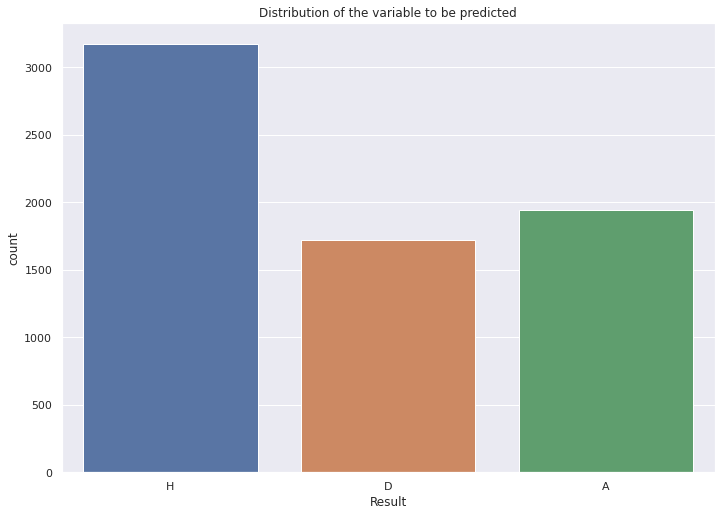

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(x = final_dataset['Result'], order=['H', 'D', 'A']).set_title('Distribution of the variable to be predicted')

As we can guess, a team is more likely to win when it plays at thome

## 3. Numerical features

We take the total goals at the end of each season : 

H_GoalsScored      8937
A_GoalsScored      8757
H_GoalsConceded    8854
A_GoalsConceded    8840
dtype: int64


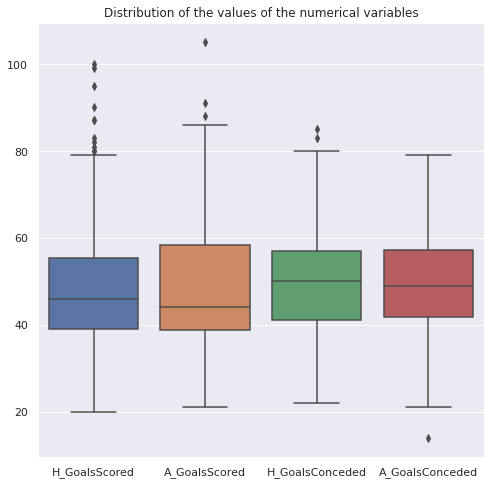

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
total_goals = final_dataset[final_dataset['MatchDay']==38]
print(total_goals[['H_GoalsScored', 'A_GoalsScored', 'H_GoalsConceded', 'A_GoalsConceded']].sum())
ax = sns.boxplot(data = total_goals[['H_GoalsScored', 'A_GoalsScored', 'H_GoalsConceded', 'A_GoalsConceded']]).set_title('Distribution of the values of the numerical variables')

Note that the sum of goals scored at home is not equal to the sum of goals conceded away from home. This is because for the last game of a season (day 38), the goals of the previous game (day 37) are available. So the goals of day 38 are not counted.

Let's now look at the distribution of the shots : 

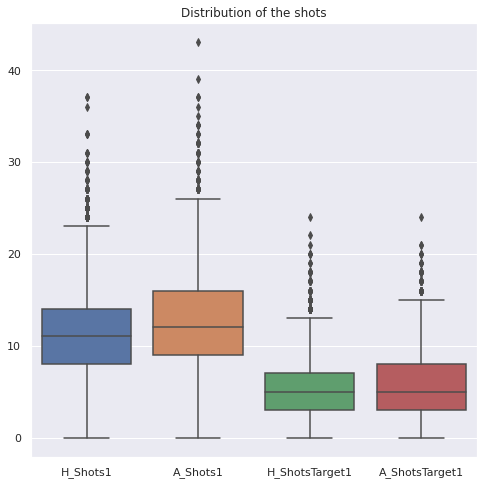

In [ ]:
goals_vars = ['H_Shots1', 'A_Shots1', 'H_ShotsTarget1', 'A_ShotsTarget1']

sns.set(rc={'figure.figsize':(8,8)})
ax = sns.boxplot(data = final_dataset[goals_vars]).set_title('Distribution of the shots')

This figure may seem odd because the distribution figure for the output variable shows that we are more likely to win when we play at home. However, this figure shows that in total, there are more shots (on target or not) for teams playing away. This seems strange because we are generally less comfortable away from home. 

Let's now look the distribution of each of these features, but for each of the three possible results :

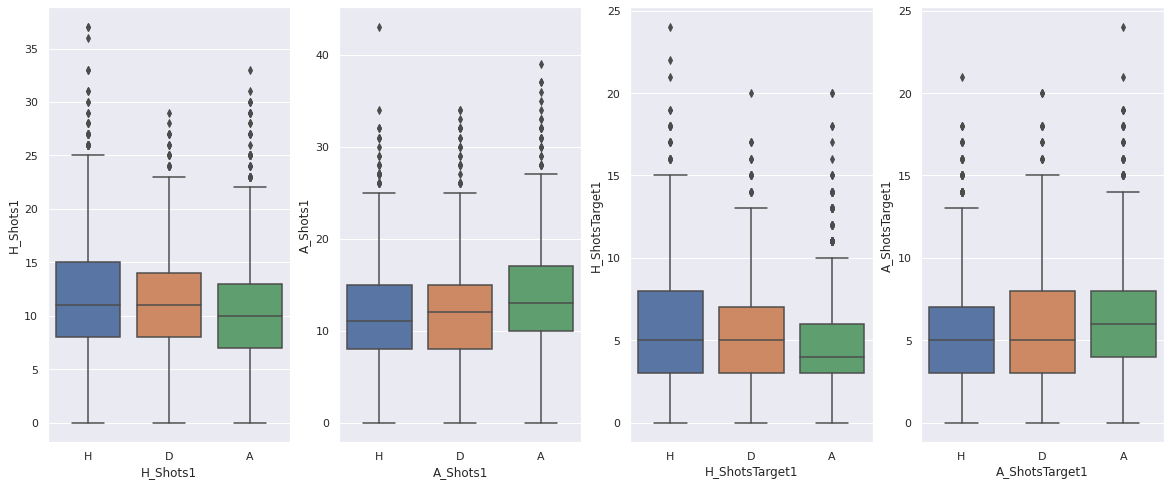

In [ ]:
plt.figure(figsize=(20,8))

for num_var in range(len(goals_vars)):
    name_col = goals_vars[num_var]
    plt.subplot(1,len(goals_vars), num_var+1)
    sns.boxplot(data=final_dataset[[name_col, 'Result']], x='Result', y=name_col, order=['H', 'D', 'A'])
    plt.xlabel(name_col)

plt.show()

In order not to overload the notebook, we interpret the first figure only : the home team tends to win when that home team put up a lot of shots last game. And on the contrary, the away team tends to win when the home team put in fewer shots last game **than average**. 

Let's now do the same for the corners :



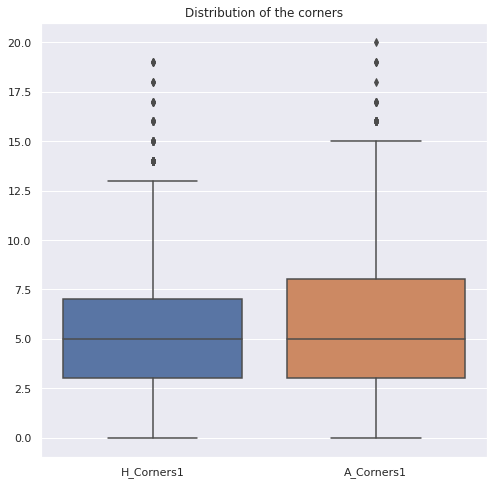

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.boxplot(data = final_dataset[['H_Corners1', 'A_Corners1']]).set_title('Distribution of the corners')

As for the shots, on average, we put more corners outside.

Let's now look the distribution of the two features, but for each of the three possible results :

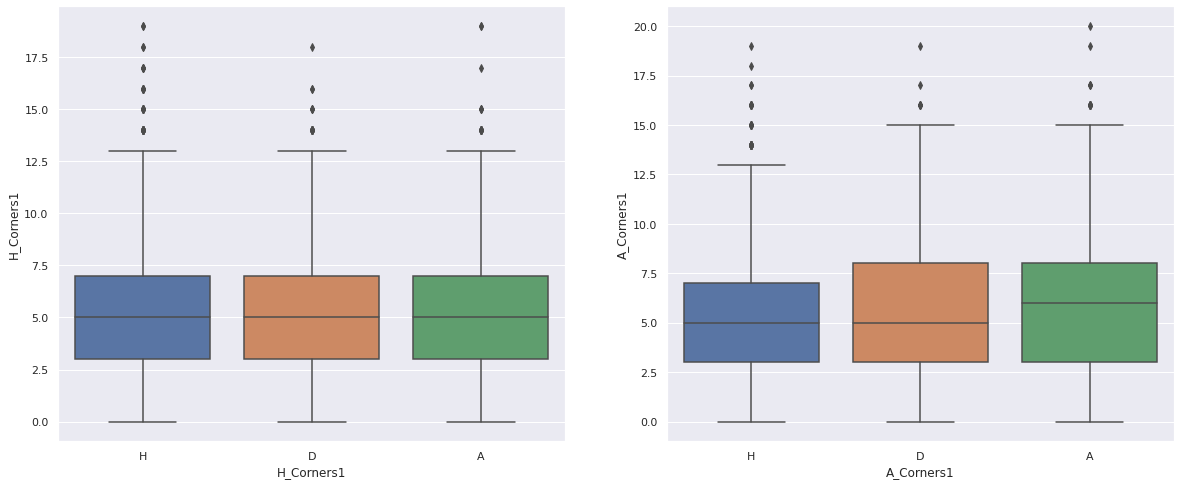

In [ ]:
plt.figure(figsize=(20,8))
corner_vars = ['H_Corners1', 'A_Corners1']
for num_var in range(len(corner_vars)):
    name_col = corner_vars[num_var]
    plt.subplot(1,len(corner_vars), num_var+1)
    sns.boxplot(data=final_dataset[[name_col, 'Result']], x='Result', y=name_col, order=['H', 'D', 'A'])
    plt.xlabel(name_col)

plt.show()

A priori, the corner is a less differentiating factor than the shots.

We observe below the corelation between numerical variables :

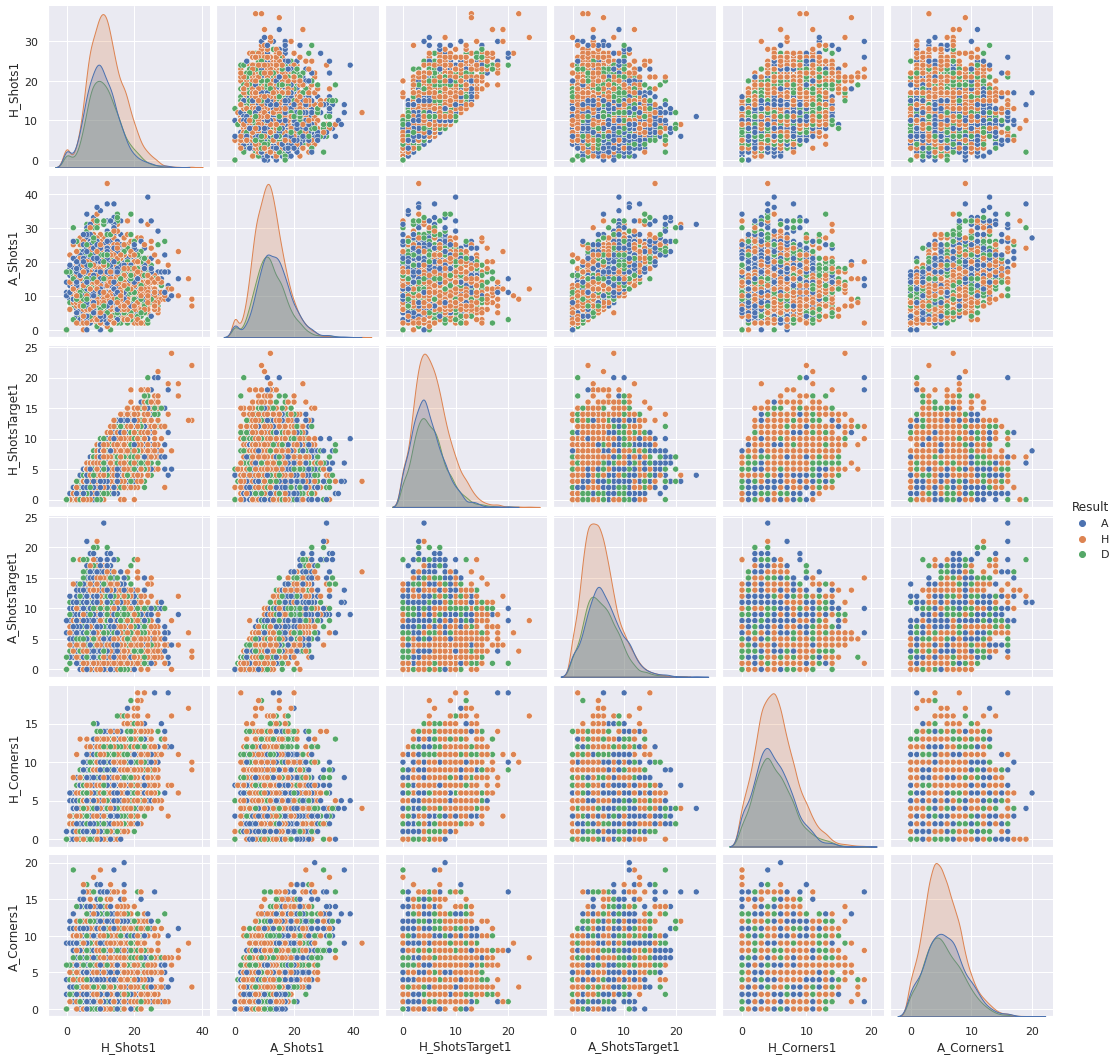

In [ ]:
ax = sns.pairplot(final_dataset[goals_vars+corner_vars+['Result']], hue = 'Result')

Shots in the last game of the home team (H_Shots1) and shots on target in the last game of the home team (H_ShotsTarget1) are correlated, which is logical. Note that these two variables are also correlated (less but still correlated a bit) with the number of corners in the last game. This is also logical. 
These remarks are also true for the Away variables.



## 4. Caterogical features

First, let's see the impact of the Home Team Name and Away Team Name on the results :

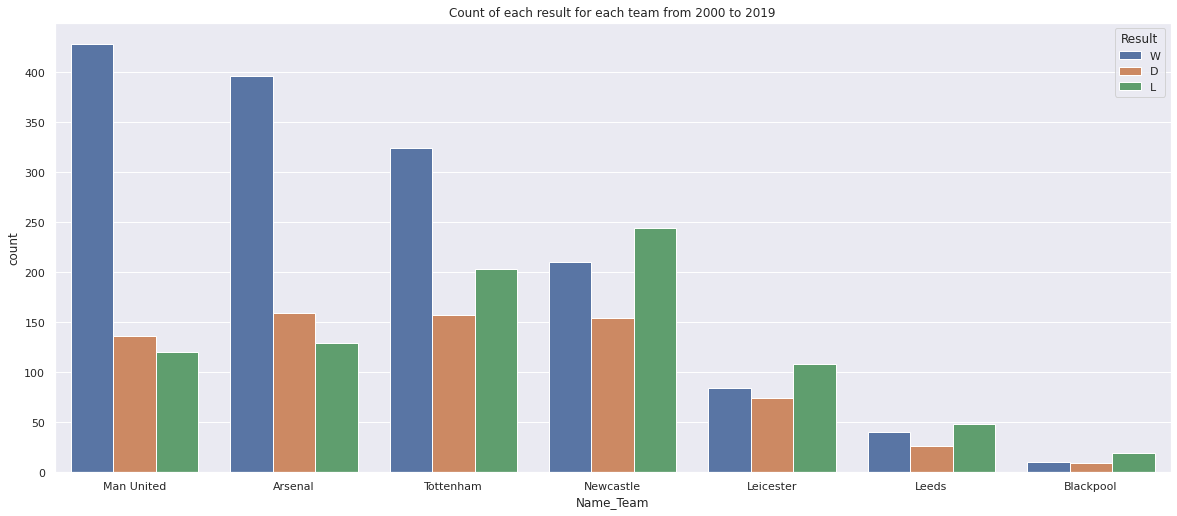

In [ ]:
all_teams = []
index=0
team_list = ["Man United", "Arsenal", "Tottenham", "Newcastle", "Leicester", "Leeds", "Blackpool"]
for name_team in team_list:
    res_list = []
    seasons = final_dataset.copy()[(final_dataset['H_name']==name_team) | (final_dataset['A_name']==name_team)]
    for num_match in range(len(seasons)):
        if seasons.iloc[num_match]['H_name']==name_team:
            if seasons.iloc[num_match]['Result'] == 'H':
                  res_list.append('W')
            elif seasons.iloc[num_match]['Result'] == 'D':
                  res_list.append('D')
            else:
                  res_list.append('L')
        else:
            if seasons.iloc[num_match]['Result'] == 'H':
                  res_list.append('L')
            elif seasons.iloc[num_match]['Result'] == 'D':
                  res_list.append('D')
            else:
                  res_list.append('W')
    all_teams.append(pd.DataFrame(columns=["Name_Team", "Result"]))
    all_teams[index]["Name_Team"] = [name_team] * len(res_list)
    all_teams[index]["Result"] = res_list
    index += 1

all_teams_df = pd.concat(all_teams, ignore_index=True)  

sns.set(rc={'figure.figsize':(20,8.27)})
ax = sns.countplot(data = all_teams_df, x = 'Name_Team', hue='Result').set_title('Count of each result for each team from 2000 to 2019')

The number of games played is important (sum of the three bars, as seen in the **Familiarization with soccer** paragraph), but also the ratio of the wins. As we go from "strong" to "weak" teams, this ratio dicreases.

Let's now have a look on 

In [ ]:
cat_cols = ['H_Results1', 'A_Results1', 'H_Results2', 'A_Results2', 'H_Results3', 'A_Results3', 'H_Red1', 'A_Red1']

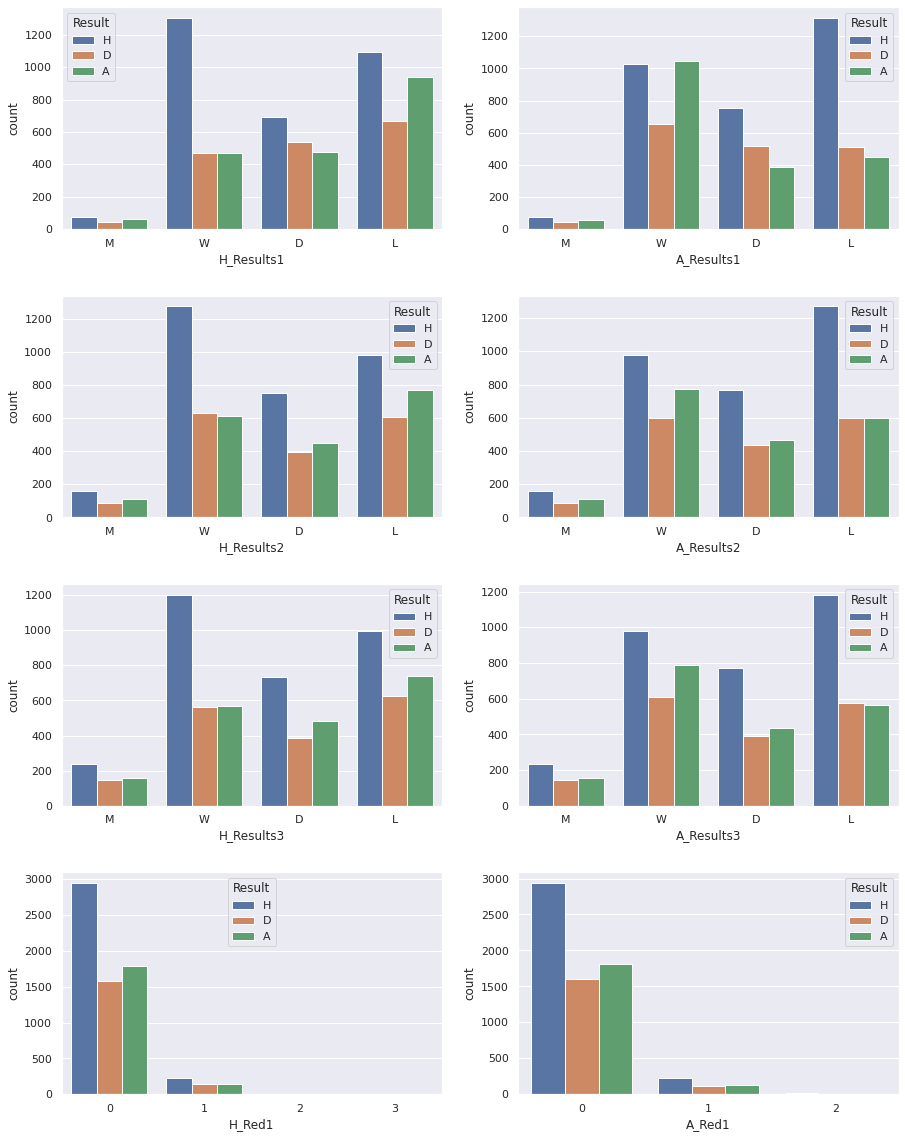

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(15,20))
for idx, cat_col in enumerate(cat_cols):
    row, col = idx//2, idx%2
    if row <=2:
        sns.countplot(data = final_dataset, x = cat_col, hue='Result',order=['M', 'W', 'D', 'L'],  hue_order=['H', 'D', 'A'], ax = axes[row, col])
    else:
        sns.countplot(data = final_dataset, x = cat_col, hue='Result',  hue_order=['H', 'D', 'A'], ax = axes[row, col])
plt.subplots_adjust(hspace=0.3)

When the home team has won its last game, it tends to win its game. On the other hand, if they lost their last game, they are still more likely to win, but less likely.

When the away team has lost its last game, it is more likely to lose its game.

Note that for the results of the second last game and the third last game, we get figures quite similar to the results of the last game.

For the red cards received in the last game, we cannot draw any intuition now.


# IV. Solving (baseline model)


In [ ]:
# Normalization of numeric variables and get_dummies for numeric variables
from sklearn.preprocessing import scale

learning_dataset = final_dataset.copy()

learning_dataset = learning_dataset.drop(columns='Date')

num_cols = ['H_GoalsScored',
          'A_GoalsScored',
          'H_GoalsConceded',
          'A_GoalsConceded',
          'H_Points',
          'A_Points',
          'H_LastPosition',
          'A_LastPosition',
          'MatchDay',
          'H_Shots1',
          'H_Shots2',
          'A_Shots1',
          'A_Shots2',
          'H_ShotsTarget1',
          'H_ShotsTarget2',
          'A_ShotsTarget1',
          'A_ShotsTarget2',
          'H_Red1',
          'A_Red1',
          'H_Corners1',
          'H_Corners2',
          'A_Corners1',
          'A_Corners2'
          ]

cat_cols = ['H_name',
          'A_name',
          'H_Results1',
          'H_Results2',
          'H_Results3',
          'A_Results1',
          'A_Results2',
          'A_Results3']

for col in num_cols:
    learning_dataset[col] = scale(final_dataset[col])

learning_dataset = pd.concat([learning_dataset.drop(columns=cat_cols), pd.get_dummies(final_dataset[cat_cols], prefix = cat_cols)], axis=1)

learning_dataset = learning_dataset.replace({'Result': {'H': 0, 'A': 1, 'D': 2}})

In [ ]:
from sklearn.model_selection import train_test_split

df_public_train, df_public_test = train_test_split(
    learning_dataset, test_size=0.2, random_state=57)

df_public_train.to_csv(loc + "data_train.csv")
df_public_test.to_csv(loc + "data_test.csv")

In [ ]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

model1 = LogisticRegression(penalty='l1', C=0.01, max_iter=10000, solver='liblinear')


y_train = df_public_train['Result'].values
X_train = df_public_train.drop(['Result'], axis=1).to_numpy()

y_test = df_public_test['Result'].values
X_test = df_public_test.drop(['Result'], axis=1).to_numpy()

model1.fit(X_train, y_train)
print('train accuracy : ' + str(model1.score(X_train, y_train)), '\n', 'test accuracy : ' + str(model1.score(X_test, y_test)))


train accuracy : 0.5356359649122807 
 test accuracy : 0.5307017543859649
